## Tutorial to simulate tissue  with transcriptomic profile sample from single cell

In the previous tutorial we assess the cell type calling accuracy obtain from the selected markers as if the RNA-cell association will be perfect in our experiment. However the RNA-cell association (aka cell segmentation) may contain some errors and it will add noise or mistake in the final cell expression vectors. To  assess to what extend the selected markers are robust to cell segmentation error, a solution is to reproduce the experimental set-up in silico through tissue simulations which allow to have a full control over the cell type and expression vector ground thruth of each cell  
With nuclei segmentation as input, our package SimTissue (https://github.com/tdefa/SimTissue) can simulate various cell shape complexity mimicking the targeted tissue with the selected marker gene.   
SimTissue can be install via pip ``pip install SimTissue `` and is described in our paper : https://www.biorxiv.org/content/10.1101/2023.12.01.569528v1.article-metrics

To simulate the smFISH experiment, The best is to start from segmentation mask of nuclei from a tissue similar to the one you want to study. 
To run this tutorial, you can download test example data of nuclei segmentation mask from mouse lung tissue : 
https://cloud.minesparis.psl.eu/index.php/s/ZXkeiJTzD6KrjRX

In [3]:
import sys
sys.path = ['/snap/pycharm-professional/368/plugins/python/helpers/pydev',
 '/snap/pycharm-professional/368/plugins/python/helpers/third_party/thriftpy',
 '/snap/pycharm-professional/368/plugins/python/helpers/pydev',
 '/snap/pycharm-professional/368/plugins/python/helpers/pycharm_display',
 '/home/tom/anaconda3/envs/comseg_v0/lib/python38.zip',
 '/home/tom/anaconda3/envs/comseg_v0/lib/python3.8',
 '/home/tom/anaconda3/envs/comseg_v0/lib/python3.8/lib-dynload',
 '/home/tom/.local/lib/python3.8/site-packages',
 '/home/tom/Bureau/phd/st_seg/ssam_merfish/ssam_pkg',
 '/home/tom/anaconda3/envs/comseg_v0/lib/python3.8/site-packages',
 '/snap/pycharm-professional/368/plugins/python/helpers/pycharm_matplotlib_backend',
 '/home/tom/Bureau/phd/simulation/ComSeg_pkg']

In [6]:
import sys
from pathlib import Path
import tifffile
import numpy as np
from simtissue.arbitrary_shape import  generate_ellipse
import time
import random
from tqdm import tqdm
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from matplotlib import pyplot as plt
from scipy import sparse
import pandas
import scanpy

from simtissue.control_expression import filter_simulation, sim_spots_from_ref_anndata
from simtissue.tissue import simulate_single_cell_mask


### LIST OF GENE TO SIMULATE from ns forest
selected_gene = ['Atp6v0d2', 'Abcg1',# AM
             'Rtkn2',  'Igfbp2', #AT1
             'Sftpc','Cxcl15', #AT2,
            'Cd79a', #B_cells
             'Ms4a2', 'Fcer1a', #Basophils
             'Ccdc153', #Ciliated
             'Scgb3a2', 'Scgb1a1',#Club
             'Cst3',#DC
             'Cdh5', 'Clec14a',  #EC
             'Inmt', 'Pcolce2', # Fibroblasts
             'C1qc', 'C1qa', 'C1qb', # 'C3ar1', #IM
             'Upk3b',# Mesotheliocytes
             'Ifitm6','Plac8',# Monocytes
            'Ms4a4b', 'Ccl5', 'Hcst', # NK_T_cells
             'Gzma', 'Ncr1',# NK_cells
             'S100a9',# Neutrophils
             'Mmrn1',#Platelets
           'Acta2','Myh11', # SMC
             'Cd3g', 'Cd3d' #T_cells
             ]



In [9]:
ref_anndata = scanpy.read('../test_set/test_anndata.h5ad')


## Generate the cytoplasm with ``simulate_single_cell_mask()``
In the next code snippet. we load existing nuclei segmentation mask and simulate the cytoplasm boundaries around eahc nuclei 

In [23]:
path_folder_mask_nuclei = "../test_set/mask_nuclei"
path_folder_cytoplasm = "../test_set/cytoplasm_mask"
path_save_ind_cyto = "../test_set/individual_cytoplasm"
Path(path_save_ind_cyto).mkdir(exist_ok=True, parents=True)



for path_mask_nuclei in Path(path_folder_mask_nuclei).glob('*.tiff'):
    print(path_mask_nuclei)
    ##load nuclei
    mask_nuclei = tifffile.imread(path_mask_nuclei)
    ## load cytoplasm
    mask_cyto = np.load(Path(path_folder_cytoplasm) / 
                                (path_mask_nuclei.name + ".npy"))
    ## 
    ind_cyto = simulate_single_cell_mask(
                            mask_nuclei,
                            cyto = mask_cyto,
                            scale=np.array([3, 1.03, 1.03]),
                            intervals_speed=[[0.5, 0.8], [1.3, 4]], ## variable speed of the watershed. 
                            median_kernel=7,
                            random_seed = None
                                      )
    np.save(Path(path_save_ind_cyto) / path_mask_nuclei.stem, ind_cyto)

../test_set/mask_nuclei/07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006.tiff


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:23<00:00,  1.49it/s]


../test_set/mask_nuclei/07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004.tiff


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:21<00:00,  1.48it/s]


## Optional remove a percentage of nuclei with  ``remove_nuclei``
In smFISH experiement, some nuclei are missing inside some cytoplasm as they where remove when the slide of tissue was cut. To simulate this phenomena we remove few nuclei and simulate cell without nuclei. 

In [24]:
path_folder_mask_nuclei_remove = "../test_set/mask_nuclei_remove"
Path(path_folder_mask_nuclei_remove).mkdir(exist_ok=True, parents=True)

from simtissue.arbitrary_shape import remove_nuclei
for path_mask_nuclei in Path(path_folder_mask_nuclei).glob('*.tiff'):
    print(path_mask_nuclei)
    print(path_mask_nuclei.name + ".npy")
    ##load nuclei
    mask_nuclei = tifffile.imread(path_mask_nuclei)
    new_mask_nuclei = remove_nuclei(
        mask_nuclei,
        percent_to_remove = 0.05,
        list_nuc_to_keep = None)
    np.save(Path(path_folder_mask_nuclei_remove) / path_mask_nuclei.stem, ind_cyto)

../test_set/mask_nuclei/07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006.tiff
07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_006.tiff.npy
../test_set/mask_nuclei/07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004.tiff
07_CtrlNI_Pdgfra-Cy3_Serpine1-Cy5_004.tiff.npy


## Simulate transcriptomic profile  with ``sim_spots_from_ref_anndata()``

In this last step, we simulate the RNA profile of each cell and the position of the RNA dots.  

For each cell, the RNA profile is sample from scRNA-seq data and then multiply by a scale factor to take into account the higher sensibility of the FISH.

The RNA position are then sample from a uniform random dsitribution accross the cell


In [31]:
path_to_save_anndata = "../test_set/anndata/"
path_to_save_df = "../test_set/dataframe/"
Path(path_to_save_anndata).mkdir(exist_ok=True, parents=True)
Path(path_to_save_df).mkdir(exist_ok=True, parents=True)

list_anndata = []

for path_ic in Path(path_save_ind_cyto).glob("*.npy"):
    
    cell_mask = np.load(path_ic)
    
    anndata, df_spots = sim_spots_from_ref_anndata(
    ref_anndata = ref_anndata,
    cell_mask = cell_mask,
    image_name = path_ic.stem, 
    annotation_column = "cell_ID",
    selected_gene = selected_gene,
    remove_neighbors = True,
    max_dist = 0.3,
    dict_scale = {"x":0.103, 'y':0.103, "z":0.300},
        )
    
    list_anndata.append(anndata)
        
    anndata.write_h5ad(str(Path(path_to_save_anndata) /(path_ic.stem + '.h5ad')))
    df_spots.to_csv(Path(path_to_save_df) /(path_ic.stem + '.csv'))                   

View of AnnData object with n_obs × n_vars = 35 × 34
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'dataset', 'project', 'experiment', 'singlecell_version', 'sexe', 'genotype', 'IRstatus', 'IRdose', 'timepoint', 'sorted', 'condition', 'percent.mt', 'nCount_RNAraw', 'nFeature_RNAraw', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'cell_ID', 'sub_cell_ID', 'family', 'sub_family'
    var: 'features'
View of AnnData object with n_obs × n_vars = 32 × 34
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'dataset', 'project', 'experiment', 'singlecell_version', 'sexe', 'genotype', 'IRstatus', 'IRdose', 'timepoint', 'sorted', 'condition', 'percent.mt', 'nCount_RNAraw', 'nFeature_RNAraw', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'cell_ID', 'sub_cell_ID', 'family', 'sub_family'
    var: 'features'


### PLOT FINAL SIMULATION 

/tmp/ipykernel_98357/1781905025.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(np.array(dico_spots_pos[gene])[:,1], np.array(dico_spots_pos[gene])[:,0], cmap="Pastel1",  #  gene_color_dico[gene],   #'#%02X%02X%02X' % (r(),r(),r()),


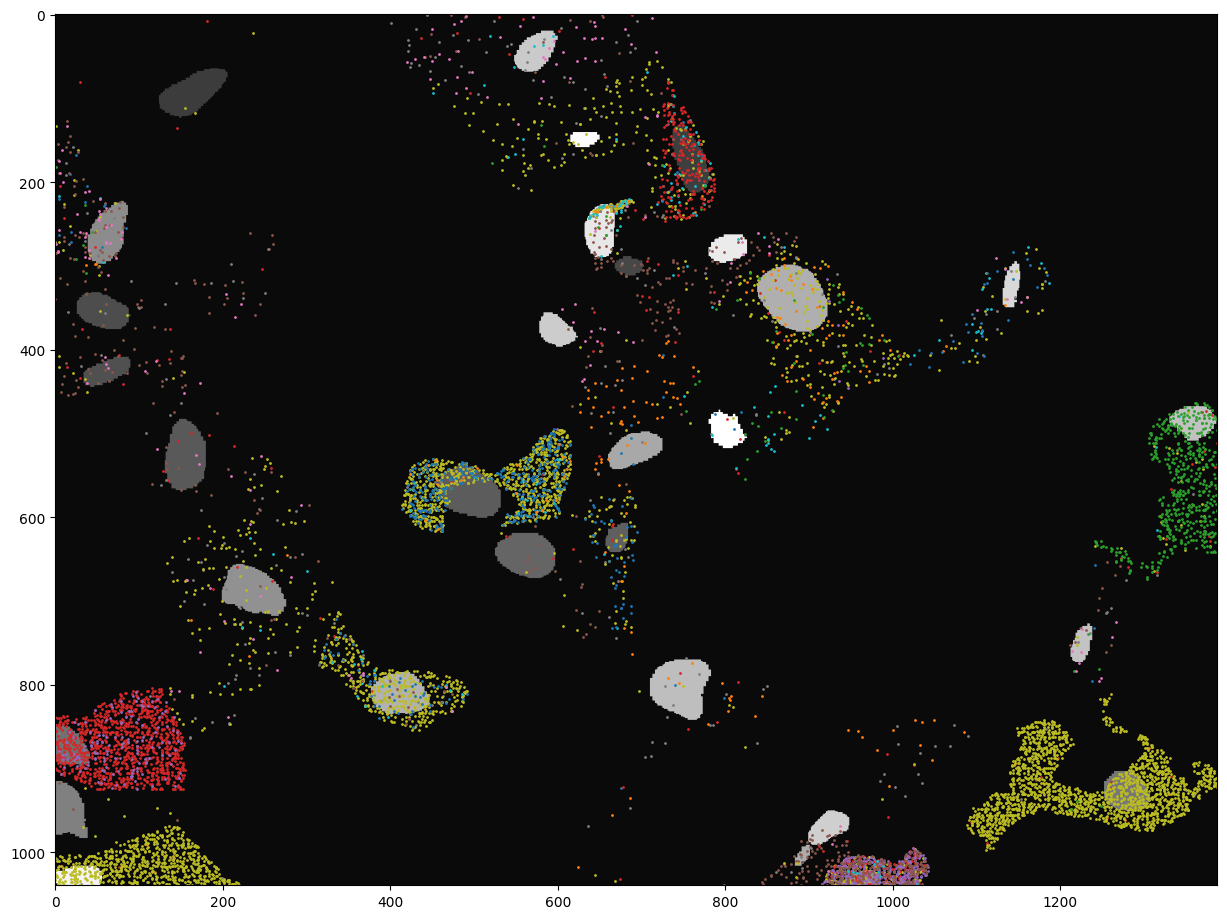

In [30]:
from matplotlib import colors
import pandas as pd
df_spots = pd.read_csv(Path(path_to_save_df) /(path_ic.stem + '.npy'))
mask_nuclei = tifffile.imread(Path(path_folder_mask_nuclei) / (path_ic.stem + '.tiff')) 
mip_nuclei = np.amax(mask_nuclei, 0)

dico_spots_pos = {}
for gene in selected_gene:
    y = df_spots[df_spots["gene"] == gene]["y"]
    x = df_spots[df_spots["gene"] == gene]["x"]

    dico_spots_pos[gene] = list(zip( y, x))
    

fig, ax = plt.subplots(figsize = (15,15))
ax.imshow(mip_nuclei > 0, cmap='gist_gray', alpha = 0.8)
ax.imshow(mip_nuclei, cmap='gist_gray', alpha = 0.8)
for gene in dico_spots_pos.keys():
    if len(dico_spots_pos[gene]) == 0:
        continue
    ax.scatter(np.array(dico_spots_pos[gene])[:,1], np.array(dico_spots_pos[gene])[:,0], cmap="Pastel1",  #  gene_color_dico[gene],   #'#%02X%02X%02X' % (r(),r(),r()),
               s=1)
plt.show()

In [28]:
df_spots

,z,y,x,gene,cell,cell_type
0,0,135,145,Sftpc,3,T_cells
1,2,81,29,Sftpc,3,T_cells
2,3,7,181,Sftpc,3,T_cells
3,2,22,236,Cst3,3,T_cells
4,3,117,167,Cst3,3,T_cells
...,...,...,...,...,...,...
8870,1,554,824,Pcolce2,69,EC
8871,2,488,832,Pcolce2,69,EC
8872,1,441,764,Pcolce2,69,EC
8873,0,473,753,Pcolce2,69,EC
